## Task to analyse the sensor data and rank the sensors according to their importance/predictive power with respect to the class labels of the samples

In [36]:
# import library
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier

from xgboost import XGBClassifier

## Data Cleaning

In [2]:
sensor_data = pd.read_csv(
    'task_data.csv'
)

In [3]:
# count number of sample related to class label
sensor_data.class_label.value_counts()

-1.0    200
 1.0    200
Name: class_label, dtype: int64

In [4]:
sensor_data.describe()

,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.000000,0.523661,0.509223,0.481238,0.509752,0.497875,0.501065,0.490480,0.482372,0.482822,0.541933
std,1.001252,0.268194,0.276878,0.287584,0.297712,0.288208,0.287634,0.289954,0.282714,0.296180,0.272490
min,-1.000000,0.007775,0.003865,0.004473,0.001466,0.000250,0.000425,0.000173,0.003322,0.003165,0.000452
25%,-1.000000,0.299792,0.283004,0.235544,0.262697,0.249369,0.269430,0.226687,0.242848,0.213626,0.321264
50%,0.000000,0.534906,0.507583,0.460241,0.510066,0.497842,0.497108,0.477341,0.463438,0.462251,0.578389
75%,1.000000,0.751887,0.727843,0.734937,0.768975,0.743401,0.738854,0.735304,0.732483,0.740542,0.768990
max,1.000000,0.999476,0.998680,0.992963,0.995119,0.999412,0.997367,0.997141,0.998230,0.996098,0.999465


In [5]:
X = sensor_data.iloc[:,2:12]  #independent columns
y = sensor_data.iloc[:,1] #class label column

In [6]:
# feature names
data_columns = np.array(list(X.columns.values))
data_columns

array(['sensor0', 'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5',
       'sensor6', 'sensor7', 'sensor8', 'sensor9'], dtype='<U7')

## Lets check the correlation between the features by creating correlation matrix

Text(0.5,1,'Correlation matrix')

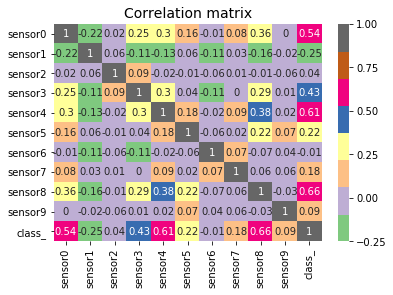

In [7]:
sns.heatmap(X.assign(class_ = y).corr().round(2), cmap = 'Accent', annot = True).set_title('Correlation matrix', fontsize = 14)

#### Correlation matrix shows that there is no correlation between the features.
#### Further, lets concentrate on drawing the importance of features using different models. 

# Model Based Ranking

#### General way to perform is that we can fit a classfier to each feature and rank the importance/predictive power. This method displays the most powerful features individually but ignores the predictive power when features are merged together.
#### One of the commonly used classifier is Decision Tree classifier
#### Decision tree builds classification or regression models in the form of a tree structure. It breaks down a data set into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed[6].


In [8]:
#decision tree
decision = DecisionTreeClassifier()
decision.fit(X, y)
scores_dec = []
num_features = len(X.columns)
for i in range(num_features):
    col = X.columns[i]
    score_dec = np.mean(cross_val_score(decision, X[col].values.reshape(-1,1), y, cv=10))
    scores_dec.append((int(score_dec*100), col))

print("Scores of individual samples:")
scores_dec = np.array(sorted(scores_dec, reverse = True))
print(scores_dec)

Scores of individual samples:
[['99' 'sensor6']
 ['78' 'sensor1']
 ['77' 'sensor8']
 ['73' 'sensor2']
 ['69' 'sensor4']
 ['64' 'sensor0']
 ['59' 'sensor5']
 ['58' 'sensor9']
 ['53' 'sensor3']
 ['49' 'sensor7']]


In [9]:
%time dec_importances = decision.feature_importances_

Wall time: 0 ns


In [10]:
# return importances
def imp_features(feature_names, importances):
    print("Feature importance of sensor data in descending order")
    imp = pd.DataFrame({'feature':feature_names , 'feature_importance':importances})\
        .sort_values('feature_importance',ascending=False)\
        .reset_index(drop = True)
    return imp

# Plot the ranking of the sensors
def plot_feature_imp(importances, title):
    plt.figure()
    indices = np.argsort(importances)[::-1]
    plt.title(title)
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [11]:
imp_features(data_columns, dec_importances)

Feature importance of sensor data in descending order


,feature,feature_importance
0,sensor8,0.587708
1,sensor6,0.343163
2,sensor0,0.047977
3,sensor1,0.009679
4,sensor7,0.008333
5,sensor4,0.003140
6,sensor2,0.000000
7,sensor3,0.000000
8,sensor5,0.000000
9,sensor9,0.000000


#### Individual feature scores are generated and displayed in descending order. Sensor8 have the highest score and sensor9 have the least score. We cannot decide that these above features with scores are final. Therefore, We need to show the importance of the feature from different classifier and fit with feature samples and target.
#### Lets work on this task to show the best predictive power by performing several experiments and try to visulaize it. This will help us understand which feature has more importance.

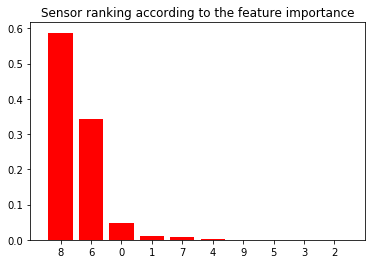

In [12]:
plot_feature_imp(dec_importances, "Sensor ranking according to the feature importance")

In [13]:
from sklearn.preprocessing import scale
def pred_power_asperclass(X, Y, feature_ranking):
    X = scale(X)
    for c in set(Y):
        df = np.mean(X[Y==c, :], axis=0)*feature_ranking
        indices = np.argsort(df)[::-1]
        feature_list = [data_columns[indices[f]] for f in range(X.shape[1])]  #names of features.
        ff = np.array(feature_list)
        print("\nClass %d" %c)
        print("Rank, Feauture_name, Value")
        for f in range(X.shape[1]):
            rank = print("%d %s %f " % (f + 1, ff[f], df[indices[f]]))
    return rank

In [14]:
print("Decision Tree Classifier\n")
print('Sensors rank with respect to class label')
pred_power_asperclass(X, y, dec_importances)

Decision Tree Classifier

Sensors rank with respect to class label

Class 1
Rank, Feauture_name, Value
1 sensor8 0.388250 
2 sensor0 0.026065 
3 sensor4 0.001908 
4 sensor7 0.001463 
5 sensor9 0.000000 
6 sensor5 0.000000 
7 sensor3 0.000000 
8 sensor2 0.000000 
9 sensor1 -0.002439 
10 sensor6 -0.002544 

Class -1
Rank, Feauture_name, Value
1 sensor6 0.002544 
2 sensor1 0.002439 
3 sensor9 -0.000000 
4 sensor5 -0.000000 
5 sensor3 -0.000000 
6 sensor2 -0.000000 
7 sensor7 -0.001463 
8 sensor4 -0.001908 
9 sensor0 -0.026065 
10 sensor8 -0.388250 


#### sensor8 have the highest score and sensor6 have the least score for class 1 and  sensor6 have the highest score and sensor8 have the least score for class -1. Ranking the feature as per the class are bit different.
#### We can also see how these features are related in the plot below.

In [15]:
# Plot the ranking of the sensors for class 1
def plot_import_asperclassone(X, Y, importances,title):
    plt.figure()
    X = scale(X)
    df = np.mean(X[Y==1, :], axis=0)*importances
    indices = np.argsort(df)[::-1]
    plt.title(title)
    plt.bar(range(X.shape[1]), df[indices],
           color="r", align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()
    
# Plot the ranking of the sensors for class -1
def plot_import_asperclassminusone(X, Y, importances,title):
    plt.figure()
    X = scale(X)
    df = np.mean(X[Y==-1, :], axis=0)*importances
    indices = np.argsort(df)[::-1]
    plt.title(title)
    plt.bar(range(X.shape[1]), df[indices],
           color="r", align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

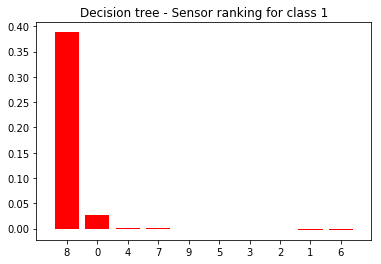

In [16]:
plot_import_asperclassone(X, y, dec_importances, "Decision tree - Sensor ranking for class 1")

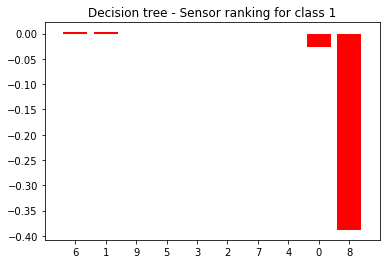

In [17]:
plot_import_asperclassminusone(X, y, dec_importances, "Decision tree - Sensor ranking for class 1")

#### Random Forest Classifier
#### A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting [1].
#### Random Forest Classifier is used in this case because it is robust, nonlinear, and doesn't require scaling.

In [18]:
#Random Forest
clf = RandomForestClassifier(n_estimators = 100, max_depth = 4)
clf.fit(X, y)
scores = []
num_features = len(X.columns)
for i in range(num_features):
    col = X.columns[i]
    score = np.mean(cross_val_score(clf, X[col].values.reshape(-1,1), y, cv=10))
    scores.append((int(score*100), col))

print("Scores of individual samples:")
scores = np.array(sorted(scores, reverse = True))
scores

Scores of individual samples:


array([['99', 'sensor6'],
       ['90', 'sensor1'],
       ['87', 'sensor8'],
       ['86', 'sensor2'],
       ['83', 'sensor4'],
       ['81', 'sensor0'],
       ['74', 'sensor5'],
       ['73', 'sensor3'],
       ['67', 'sensor9'],
       ['63', 'sensor7']], dtype='<U11')

#### Individual feature scores are generated and displayed in descending order. We can see that model has performed very well on the data.
#### sensor6 have the highest score and sensor7 have the least score. We cannot decide that these above feature with scores are final. Therefore, we need to show the importance of the feature from different classifier and fit with feature samples and target.
#### Lets work on this task to show the best predictive power by performing several experiments and try to visulaize it. This will help us to understand which feature has to be given more importance.

In [19]:
# function for creating a feature importance dataframe
%time rfc_importances = clf.feature_importances_
imp_features(data_columns, rfc_importances)

Wall time: 16 ms
Feature importance of sensor data in descending order


,feature,feature_importance
0,sensor8,0.248492
1,sensor4,0.215785
2,sensor6,0.200522
3,sensor0,0.150073
4,sensor3,0.055249
5,sensor2,0.045653
6,sensor1,0.035744
7,sensor5,0.020879
8,sensor9,0.014799
9,sensor7,0.012804


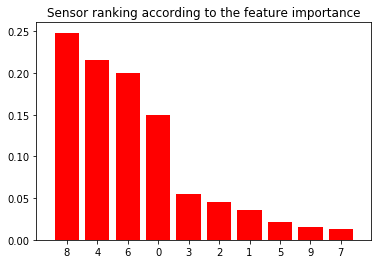

In [20]:
plot_feature_imp(rfc_importances, "Sensor ranking according to the feature importance")

#### As we can see that random forest classifier provides feature importance, the top features are sensor8, sensor6, and sensor4 [2].
#### Lets rank the feature with respect to the class labels using random forest classifier and how it works individually.

In [21]:
print("Random Forest Classifier\n")
print('Sensors rank with respect to class label')
pred_power_asperclass(X, y, rfc_importances)

Random Forest Classifier

Sensors rank with respect to class label

Class 1
Rank, Feauture_name, Value
1 sensor8 0.164158 
2 sensor4 0.131116 
3 sensor0 0.081534 
4 sensor3 0.023958 
5 sensor5 0.004680 
6 sensor7 0.002249 
7 sensor2 0.001770 
8 sensor9 0.001404 
9 sensor6 -0.001487 
10 sensor1 -0.009008 

Class -1
Rank, Feauture_name, Value
1 sensor1 0.009008 
2 sensor6 0.001487 
3 sensor9 -0.001404 
4 sensor2 -0.001770 
5 sensor7 -0.002249 
6 sensor5 -0.004680 
7 sensor3 -0.023958 
8 sensor0 -0.081534 
9 sensor4 -0.131116 
10 sensor8 -0.164158 


#### As per the class label sensor8, sensor4 and sensor0 is top for class 1 and sensor1, sensor6, sensor9 is top for class -1.
#### class -1 is the reversed of class 1 as we can notice that.
#### From the plot below also explains the same, and we can notice that as the feature goes downside there is drastic changes in the value which is not at all correlated to each other. For class -1 it is negative value.

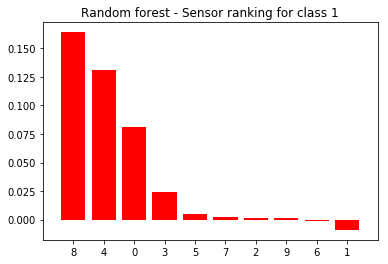

In [22]:
plot_import_asperclassone(X, y, rfc_importances, "Random forest - Sensor ranking for class 1")

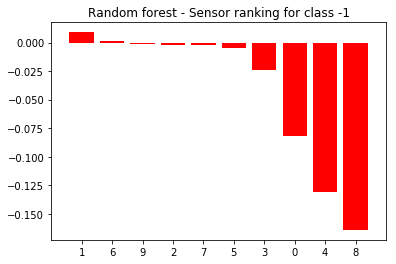

In [23]:
plot_import_asperclassminusone(X, y, rfc_importances, "Random forest - Sensor ranking for class -1")

#### This default feature importance doesn't gives a proper picture of feature importance. This is because that there is bias involved in this method[3] . Another issue is the collinearity and the inflation towards the continous values.

#### Hence we need to find a better method.

## Extra Trees Classifier
#### Extremely Randomized Trees Classifier(Extra Trees Classifier) is a type of ensemble learning technique which aggregates the results of multiple de-correlated decision trees collected in a “forest” to output it's classification result. This concept, is very similar to a Random Forest Classifier and only differs from it in the manner of construction of the decision trees in the forest[4].

In [24]:
#extra tree
#split to training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

# define classifier and fitting data
forest = ExtraTreesClassifier(random_state=1)
forest.fit(X_train, y_train)

#Applying 10-fold cross validation
accuracies = cross_val_score(estimator=forest, X=X_train, y=y_train, cv=10)
print("Accuracy (10-fold): ", np.mean(accuracies))

# Features importances
%time etc_importances = forest.feature_importances_

Accuracy (10-fold):  0.9679802955665024
Wall time: 0 ns


In [25]:
# function for creating a feature importance dataframe
imp_features(data_columns, etc_importances)

Feature importance of sensor data in descending order


,feature,feature_importance
0,sensor8,0.209768
1,sensor6,0.200965
2,sensor0,0.159766
3,sensor4,0.158863
4,sensor1,0.085588
5,sensor3,0.058358
6,sensor2,0.040734
7,sensor9,0.031502
8,sensor5,0.030630
9,sensor7,0.023825


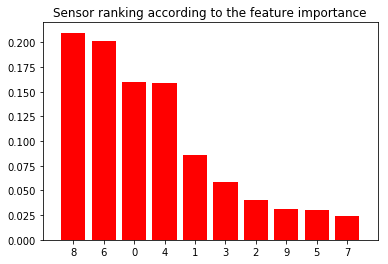

In [26]:
plot_feature_imp(etc_importances, "Sensor ranking according to the feature importance")

In [27]:
print("Extra Trees Classifier\n")
print('Sensors rank with respect to class label')
%time pred_power_asperclass(X, y, etc_importances)

Extra Trees Classifier

Sensors rank with respect to class label

Class 1
Rank, Feauture_name, Value
1 sensor8 0.138576 
2 sensor4 0.096529 
3 sensor0 0.086800 
4 sensor3 0.025306 
5 sensor5 0.006866 
6 sensor7 0.004184 
7 sensor9 0.002990 
8 sensor2 0.001579 
9 sensor6 -0.001490 
10 sensor1 -0.021569 

Class -1
Rank, Feauture_name, Value
1 sensor1 0.021569 
2 sensor6 0.001490 
3 sensor2 -0.001579 
4 sensor9 -0.002990 
5 sensor7 -0.004184 
6 sensor5 -0.006866 
7 sensor3 -0.025306 
8 sensor0 -0.086800 
9 sensor4 -0.096529 
10 sensor8 -0.138576 
Wall time: 15.6 ms


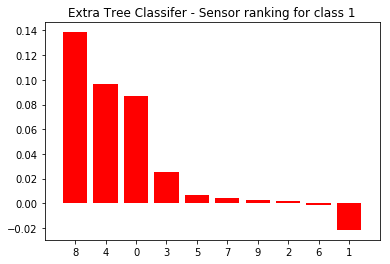

In [28]:
plot_import_asperclassone(X, y, etc_importances, "Extra Tree Classifer - Sensor ranking for class 1")

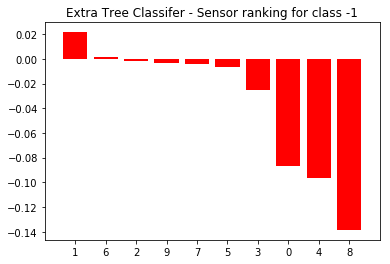

In [29]:
plot_import_asperclassminusone(X, y, etc_importances, "Extra Tree Classifer - Sensor ranking for class -1")

#### As we can notice that the extra tree method gives almost same result when compared to the random forest and decision tree's feature importance. In this result also sensor8 turned out to be more important for class 1 and sensor1 for class -1.

#### This method shows us a way where in we can check how the score will reduce if a particular feature importance changes from model to model. Since the number of features present is not more for this problem, this method is not power intensive(resource consumption), otherwise it might suffer if the number of features increase.

## Xgboost Method
#### XGBoost (Extreme Gradient Boosting) belongs to a family of boosting algorithms and uses the gradient boosting (GBM) framework at its core. It is an optimized distributed gradient boosting library.
#### Boosting is a sequential technique which works on the principle of an ensemble. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher. Note that a weak learner is one which is slightly better than random guessing [5].

In [30]:
# Xgboost
import warnings
warnings.filterwarnings("ignore")
xgb = XGBClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True, random_state=42)
xgb.fit(X, y)

#Applying 10-fold cross validation
xgb_accuracy = cross_val_score(estimator=xgb, X=X_train, y=y_train, cv=10)
print("Accuracy (10-fold): ", np.mean(xgb_accuracy))

# Features importances
%time xgb_importances = xgb.feature_importances_

Accuracy (10-fold):  0.9928571428571429
Wall time: 0 ns


In [31]:
# function for creating a feature importance dataframe
imp_features(data_columns, xgb_importances)

Feature importance of sensor data in descending order


,feature,feature_importance
0,sensor8,0.661009
1,sensor6,0.130181
2,sensor4,0.088022
3,sensor0,0.050873
4,sensor2,0.027038
5,sensor1,0.022148
6,sensor9,0.017939
7,sensor3,0.002789
8,sensor5,0.000000
9,sensor7,0.000000


#### Xgboost method comparing to other method from previous, score has been increased from ~96% to ~99%. This helped us to overcome the issue of collinearity which the default feature importance method suffer's with.

#### This method shows us a way where in we can check how the score will increase due to the collinearity issue.

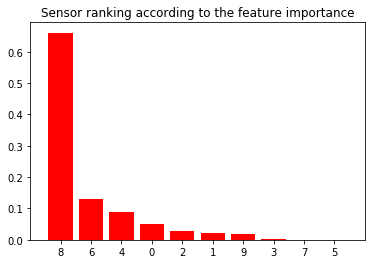

In [32]:
plot_feature_imp(xgb_importances, "Sensor ranking according to the feature importance")

In [33]:
print("Xgboost Classifier\n")
print('Sensors rank with respect to class label')
%time pred_power_asperclass(X, y, xgb_importances)

Xgboost Classifier

Sensors rank with respect to class label

Class 1
Rank, Feauture_name, Value
1 sensor8 0.436675 
2 sensor4 0.053484 
3 sensor0 0.027639 
4 sensor9 0.001703 
5 sensor3 0.001210 
6 sensor2 0.001048 
7 sensor7 0.000000 
8 sensor5 0.000000 
9 sensor6 -0.000965 
10 sensor1 -0.005581 

Class -1
Rank, Feauture_name, Value
1 sensor1 0.005581 
2 sensor6 0.000965 
3 sensor7 -0.000000 
4 sensor5 -0.000000 
5 sensor2 -0.001048 
6 sensor3 -0.001210 
7 sensor9 -0.001703 
8 sensor0 -0.027639 
9 sensor4 -0.053484 
10 sensor8 -0.436675 
Wall time: 15.6 ms


#### Here, sensor 8 is still an important feature and is the top value for class 1 and sensor1 for class -1. As we can notice that by using this method we got the similar result as we obtained in previous methods except that the score increases only.

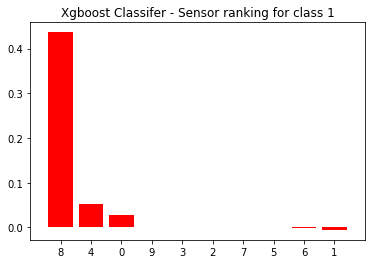

In [34]:
plot_import_asperclassone(X, y, xgb_importances, "Xgboost Classifer - Sensor ranking for class 1")

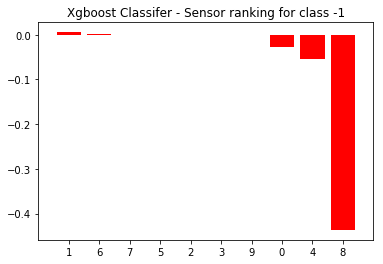

In [35]:
plot_import_asperclassminusone(X, y, xgb_importances, "Xgboost Classifer - Sensor ranking for class -1")

# Take Aways:

#### On the whole sensor 8 turns out to be an important feature. I have also explained the reasons for chosing the models and methods. The Xgboost method helps us to identify the feature importance by eliminating bias. 
#### Scikit learn default feature_importance gives the same result with accuracy and predictive power but Xgboost feature importance gives different results with the increase in accuracy because in boosting as we saw there is not much correlation between the features , boosting will use the feature that is not correlated since correlated feature will not be used in the splitting process.

#### Scalability of the methods with respect to number of features and/or samples changes each time we execute the models and the time is very less as the dataset is small. However these methods might suffer when applied on large datasets.
#### Surprisingly, feature importance are ranked same as the other methods as well.

#### This tells that with either of the methods feature 8 stands on top of values and other feature are also ranked same from every models described above.

## References
### 1. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
### 2. https://scikit-learn.org/stable/modules/feature_selection.html
### 3. https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#varimp
### 4. https://www.geeksforgeeks.org/ml-extra-tree-classifier-for-feature-selection/
### 5. https://www.datacamp.com/community/tutorials/xgboost-in-python
### 6. https://medium.com/@chiragsehra42/decision-trees-explained-easily-28f23241248